In [7]:
import torch
import numpy as np
from torch.nn import Parameter
from control_stork import activations, initializers
from control_stork.nodes import CellGroup
from typing import Optional, Tuple, List
import matplotlib.pyplot as plt

In [147]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
class ALIFGroup(CellGroup):
    def __init__(
        self,
        shape,
        tau_mem=10e-3,
        tau_syn=5e-3,
        tau_ada=200e-3,
        threshold=1.0,
        threshold_decay=0.0,
        threshold_xi=0.0,
        learn_mem:bool=False,
        learn_syn:bool=False,
        learn_ada:bool=False,
        learn_param:str='tau',
        mem_param:str='full',
        syn_param:str='full',
        ada_param:str='full',
        reset:str='sub',
        diff_reset:bool=False,
        activation=activations.SigmoidSpike,
        dropout_p:float=0.0,
        stateful:bool=False,
        name:str="ALIFGroup",
        regularizers:Optional[list]=None,
        **kwargs
    ):

        super(ALIFGroup, self).__init__(
            shape,
            dropout_p=dropout_p,
            stateful=stateful,
            name=name,
            regularizers=regularizers,
            spiking=True,
            **kwargs
        )

        self.tau_mem_init = tau_mem
        self.tau_syn_init = tau_syn
        self.tau_ada_init = tau_ada
        self.threshold = threshold
        self.threshold_decay = threshold_decay
        self.threshold_xi = threshold_xi
        self.learn_mem = learn_mem
        self.learn_syn = learn_syn
        self.learn_ada = learn_ada
        self.learn_param = learn_param
        self.mem_param = mem_param.lower()
        assert mem_param in ["full", "single"], "mem_param must be either 'full' or 'single'"
        self.syn_param = syn_param.lower()
        assert syn_param in ["full", "single"], "syn_param must be either 'full' or 'single'"
        self.ada_param = ada_param.lower()
        assert ada_param in ["full", "single"], "ada_param must be either 'full' or 'single'"
        self.reset = reset.lower()
        assert self.reset in ["sub", "set"], "reset must be either 'sub' or 'set'"
        self.reset_mem = self.subtractive_reset if self.reset == "sub" else self.multiplicative_reset
        self.diff_reset = diff_reset
        self.activation = activation
        self.spk_nl = self.activation.apply
        self.constraints = {}

        self.mem = None
        self.syn = None
        self.out = self.rst = None
        self.bt = None
        self.nt = None
        self.vt = None

    def configure(self, time_step, device, dtype):
        self.dt = time_step
        # initialize learnable parameters and apply constraints
        if self.learn_param == 'tau':
            self._tau_mem = torch.nn.Parameter(
                torch.ones(self.shape if self.mem_param == 'full' else 1, device=device) * self.tau_mem_init,
                requires_grad=self.learn_mem
            )
            self.constraints[self._tau_mem] = (1e-3, torch.inf)
            self._tau_syn = torch.nn.Parameter(
                torch.ones(self.shape if self.syn_param == 'full' else 1, device=device) * self.tau_syn_init,
                requires_grad=self.learn_syn
            )
            self.constraints[self._tau_syn] = (1e-3, torch.inf)
            self._tau_ada = torch.nn.Parameter(
                torch.ones(self.shape if self.ada_param == 'full' else 1, device=device) * self.tau_ada_init,
                requires_grad=self.learn_ada
            )
            self.constraints[self._tau_ada] = (1e-3, torch.inf)
            self.apply_constraints()
            self._beta_mem = self.tau_to_beta(self._tau_mem)
            self._beta_syn = self.tau_to_beta(self._tau_syn)
            self._beta_ada = self.tau_to_beta(self._tau_ada)

        elif self.learn_param == 'beta':
            self._beta_mem = torch.nn.Parameter(
                self.tau_to_beta(torch.ones(self.shape if self.mem_param == 'full' else 1, device=device) * self.tau_mem_init),
                requires_grad=self.learn_mem
            )
            self.constraints[self._beta_mem] = (0.37, 0.999)
            self._beta_syn = torch.nn.Parameter(
                self.tau_to_beta(torch.ones(self.shape if self.syn_param == 'full' else 1, device=device) * self.tau_syn_init),
                requires_grad=self.learn_syn
            )
            self.constraints[self._beta_syn] = (0.37, 0.999)
            self._beta_ada = torch.nn.Parameter(
                self.tau_to_beta(torch.ones(self.shape if self.ada_param == 'full' else 1, device=device) * self.tau_ada_init),
                requires_grad=self.learn_ada
            )
            self.constraints[self._beta_ada] = (0.37, 0.999)
            self.apply_constraints()
            self._tau_mem = self.beta_to_tau(self._beta_mem)
            self._tau_syn = self.beta_to_tau(self._beta_syn)
            self._tau_ada = self.beta_to_tau(self._beta_ada)

        super().configure(time_step, device, dtype)

    def apply_constraints(self):
        for param, (min_val, max_val) in self.constraints.items():
            param.data = torch.clamp(param.data, min_val, max_val)
    
    def tau_to_beta(self, tau):
        return torch.exp(-self.dt / tau)
    
    def beta_to_tau(self, beta):
        return -self.dt / torch.log(beta)

    def multiplicative_reset(self, mem, rst):
        return mem * (1.0 - rst)
    
    def subtractive_reset(self, mem, rst):
        return mem - self.vt * rst

    def get_spike_and_reset(self, mem):
        mthr = mem - self.vt

        out = self.spk_nl(mthr)
        if self.diff_reset:
            rst = out
        else:
            # if differentiation should not go through reset term, detach it from the computational graph
            rst = out.detach()

        return out, rst

    def reset_state(self, batch_size: int = 1):
        super().reset_state(batch_size)
        self.apply_constraints()
        if self.learn_param == 'tau':
            if self.learn_syn: self._beta_syn = self.tau_to_beta(self._tau_syn)
            if self.learn_mem: self._beta_mem = self.tau_to_beta(self._tau_mem)
            if self.learn_ada: self._beta_ada = self.tau_to_beta(self._tau_ada)
        elif self.learn_param == 'beta':
            if self.learn_syn: self._tau_syn = self.beta_to_tau(self._beta_syn)
            if self.learn_mem: self._tau_mem = self.beta_to_tau(self._beta_mem)
            if self.learn_ada: self._tau_ada = self.beta_to_tau(self._beta_ada)
        self.mem = self.get_state_tensor("mem", state=self.mem)
        self.syn = self.get_state_tensor("syn", state=self.syn)
        self.out = self.rst = self.get_state_tensor("out", state=self.out)
        if self.threshold_decay > 0.0:
            self.bt = self.get_state_tensor("bt", state=self.bt, init=self.threshold)
        else:
            self.bt = self.threshold
        if self.threshold_xi > 0.0:
            self.nt = self.get_state_tensor("nt", state=self.nt)
        else:
            self.nt = 0.0
        self.vt = self.states["vt"] = self.bt + self.threshold_xi * self.nt

    def forward(self):
        self.syn = self.states["syn"] = self.syn * self._beta_syn + self.input
        self.mem = self.states["mem"] = self.mem * self._beta_mem + self.syn * (1.0 - self._beta_mem) - self.rst * self.vt   
        self.out, self.rst = self.get_spike_and_reset(self.mem)
        self.states["out"] = self.out
        self.bt = self.states["bt"] = self.bt - self.threshold_decay * self.dt + (self.threshold - self.bt) * self.rst
        self.nt = self.states["nt"] = self.nt * self._beta_ada + (1.0 - self._beta_ada) * self.rst
        self.vt = self.states["vt"] = self.bt + self.threshold_xi * self.nt

    @property
    def tau_mem(self):
        return self._tau_mem

    @property
    def tau_syn(self):
        return self._tau_syn

    @property
    def tau_ada(self):
        return self._tau_ada

    @property
    def beta_mem(self):
        return self._beta_mem

    @property
    def beta_syn(self):
        return self._beta_syn

    @property
    def beta_ada(self):
        return self._beta_ada

In [117]:
n_neurons = 2
batch_size = 1
dt = 1e-3
T = 1000

In [152]:
alif = ALIFGroup(
    shape=n_neurons,
    tau_mem=10e-3,
    tau_syn=5e-3,
    tau_ada=200e-3,
    threshold=1.0,
    threshold_decay=1.5,
    threshold_xi=50.0,
    learn_mem=True,
    learn_syn=True,
    learn_ada=True,
    learn_param='tau',
    mem_param='single',
    syn_param='full',
    ada_param='full',
    reset='sub',
    diff_reset=False,
    clamp_mem=False,
    activation=activations.SigmoidSpike,
    dropout_p=0.0,
    stateful=False,
    name="ALIFGroup",
    regularizers=None,
    store_sequences=['mem', 'syn', 'out', 'bt', 'nt', 'vt']
)

alif.configure(dt, device, torch.float32)
alif.reset_state()

In [153]:
print(alif.beta_mem)
print(alif.bt, alif.nt, alif.vt)

tensor([0.9048], device='cuda:0', grad_fn=<ExpBackward0>)
tensor([[1., 1.]], device='cuda:0') tensor([[0., 0.]], device='cuda:0') tensor([[1., 1.]], device='cuda:0')


In [154]:
inpt = torch.randn(T, batch_size, n_neurons, device='cuda', dtype=torch.float32) * 1
inpt = torch.Tensor([[1, 0]]).unsqueeze(0).repeat(T, 1, 1).to('cuda')
inpt = torch.Tensor([[1, 0]] * T).to(device)


alif.reset_state(batch_size=batch_size)
for i in range(T):
    alif.input = inpt[i]
    alif.evolve()


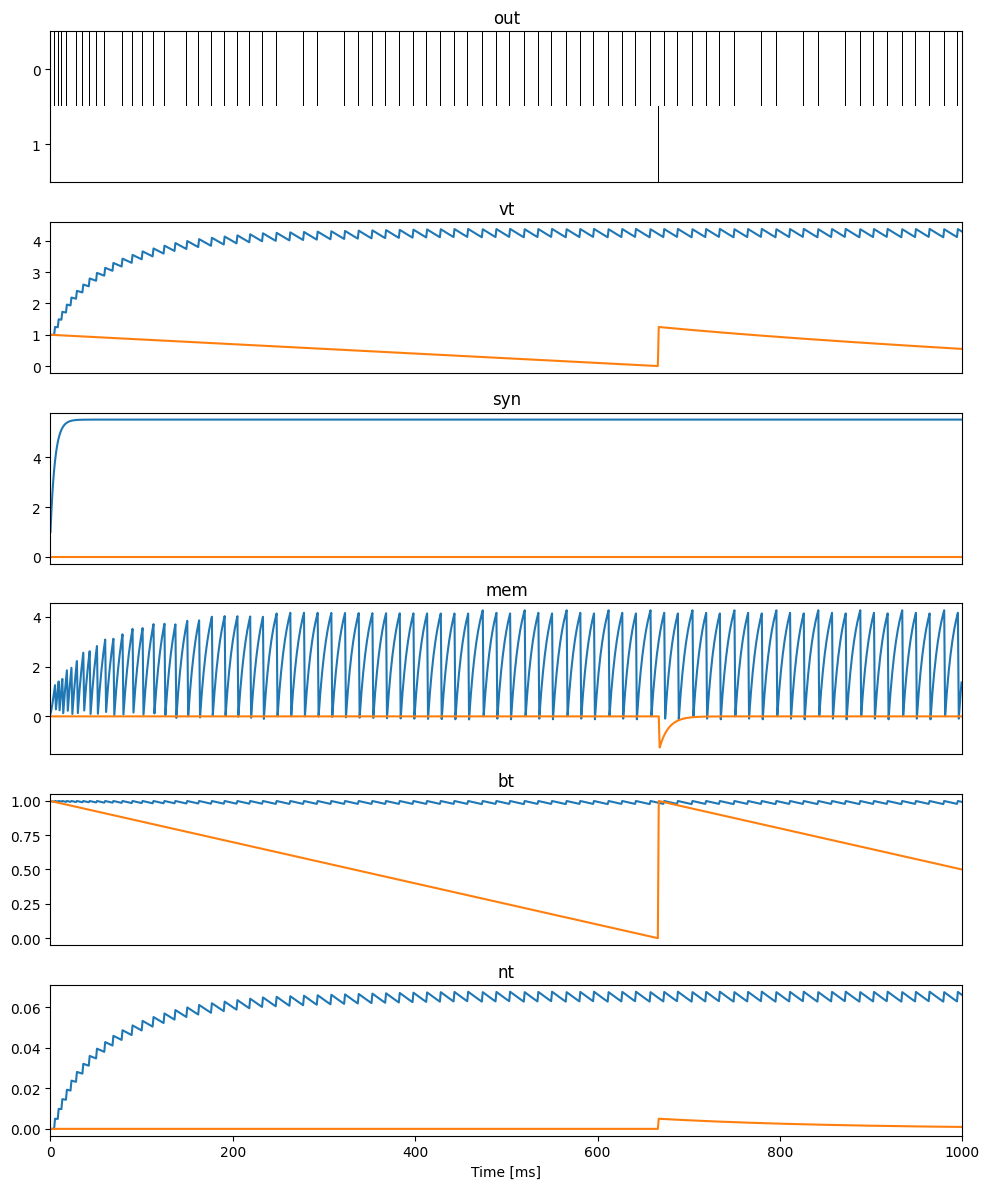

In [155]:
n = len(alif.stored_sequences_)
fig, axs = plt.subplots(n, 1, figsize=(10, 2*n))

for i, (key, value) in enumerate(alif.stored_sequences_.items()):
    data = alif.get_state_sequence(key).cpu().detach().squeeze().numpy()
    if key == 'out':
        axs[i].matshow(data.T, aspect='auto', cmap='binary')
    else:
        axs[i].plot(data)
    axs[i].set_xlim([0, T])
    axs[i].set_title(key)
    if i < n-1:
        axs[i].set_xticks([])

axs[i].set_xlabel('Time [ms]')
plt.tight_layout()
plt.show()